### Capstone Project
#### Data Acquisition
First step is to acquire a large dataset of openly available academic abstracts published in recent years in Computer Science field. 
For this step, `database.py` Python script  scapes abstract text and the corresponding authors' names from [https://arxiv.org](https://arxiv.org). I loop over publications from February, 2017 back to February, 2012 to collect 5 years worth of abstracts and store the data in sqlite database `Articles` so I would only have to do this once and then work with the database. 

#### Preprocessing
As a standard NLP text cleaning step, I convert the text words to lower case, remove the digits and punctuation and then stem the words using Snowball Stemmer before storing preprocessed text in the database.

Working with the Articles databse, `count_db.py` Python script counts the number of publications per author and writes the results in sqlite table `Counts`. Next, I can sort the authors by the number of publications or filter out authors that only have a few publications. 

I cast the problem as a multiclass classification problem and propose to use a convolutional neural network (CNN) model as a solution. 

### Data Exploration
The full dataset contains 87,587 abstracts from 2/2012 through 2/2017. 

First, I want to test my convolutional neural network model against benchmark logistic regression model with a much smaller subset of data, using top only authors with 100 or more abstracts. 

I count the number of articles per author to filter out authors with less than 20 abstracts assuming that 20 publications will be sufficient to train and test the classifier. Overall, there are 107,947 authors with the article count ranging from 166 to 1. If I limit the minimum number of articles per author to 10 then there are 4027 authors. If I limit the minimum number of articles per author to 20 then there are 922 authors.

But for simplicity and computational time sake, `cnn.py` Python script limits the number of authors to 10 and compares logistic regression benchmark and CNN models as a proxy to larger number of classes and amount of data.

In [1]:
import sqlite3
conn = sqlite3.connect('articles.sqlite')
cur = conn.cursor()

# select top authors
top_author = 'SELECT author_unique FROM Counts WHERE count >= 50 ORDER BY count DESC LIMIT 10'

author_doc = []
author_lst = []

for i in cur.execute(top_author) :
    author_lst.append(i[0])
print "number of unique authors: ", len(author_lst)

number of unique authors:  10


I use Pandas library to build a dataframe with one column containing the author and the second column - abstract text. In the database, we might have several authors who collaborated on the publication. So, we want to split the authors and then append the author name and abstract text into a big dataframe. We end up with 1772 abstracts in the dataframe among these top 10 authors. 

In [2]:
import itertools
import pandas as pd

d={}
list_authors = []
for i, author_correct in enumerate(author_lst):

    cur.execute('''SELECT abstract, author FROM Articles WHERE author LIKE ? ''', ('%{}%'.format(author_correct), ) )
    all_rows = cur.fetchall()

    authors_list = [x[1] for x in all_rows]
    docs = [x[0] for x in all_rows]

    for author, row in itertools.izip(authors_list, docs) :
        authors = author.split('; ')
        for a in authors:
            if author_correct == a:
                author_doc.append(row)
                list_authors.append(a)
    conn.commit()

df = pd.DataFrame({'author' : list_authors, 'doc': author_doc})
print "size: ", df.shape
print df.head()

cur.close()

size:  (1172, 2)
            author                                                doc
0  Rumpe, Bernhard  code generat is regard as an essenti part of m...
1  Rumpe, Bernhard  biolog nervous system exhibit astonish complex...
2  Rumpe, Bernhard  generat softwar from abstract model is a prime...
3  Rumpe, Bernhard  templatebas code generat develop as part of mo...
4  Rumpe, Bernhard  mani textual softwar languag share common conc...


We can count the number of publications per author to make sure the counts correspond to what we see in the database. As expected, Bernhard Rumpe is the top author with 166 publications and Loet Leydesdorff is the tenth author iwth 96 publications in the database. 

In [3]:
print df['author'].value_counts()

Rumpe, Bernhard          166
Bengio, Yoshua           137
Poor, H. Vincent         133
Zhang, Rui               123
Schober, Robert          114
Alouini, Mohamed-Slim    106
Shen, Chunhua            102
Popovski, Petar           98
Aickelin, Uwe             97
Leydesdorff, Loet         96
Name: author, dtype: int64


For CNN model, we want to make sure all the documents are the same length meanining they contain the same amount of words. So, we pad shorter documents to be the same length as the longest document. The longest abstract has 319 words.

In [4]:
vocab = []
lengths = []

for i in range(df.shape[0]):
    doc = df['doc'][i]
    doc_split = doc.split(" ")
    lengths.append(len(doc_split))

max_length = max(lengths)
print "max doc length: ", max_length      

for i in range(df.shape[0]):
    doc = df['doc'][i]
    doc_split = doc.split(" ")
    # How much to pad each doc
    padding_num = max_length - len(doc_split)
    doc_new = doc + " </PAD>" * padding_num
    words = doc_new.split(" ")
    vocab.append(words)


max doc length:  319


Instead of dealing with text directly, we want to build a vocabulary of words and then map words to index to convert text to integer vectors for input to CNN model. We first count the words, build an index and then a mapping from index to a word. The size of our vocabulary is the total number of unique words which is 7,247 words. The input data is now converted into integer vectors with the length of 319 for each abstract.

In [5]:
from collections import Counter
import numpy as np

word_counts = Counter(itertools.chain(*vocab))

# Mapping from index to word
vocabulary_inv = [x[0] for x in word_counts.most_common()]

# Mapping from word to index
vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}

# Map docs and labels (authors) to vectors based on a vocabulary
print "vocab shape: ", len(vocabulary)
x = np.array([ [ vocabulary[word] for word in doc ] for doc in vocab ])
print "x size: ", x.shape

vocab shape:  7247
x size:  (1172, 319)


We want to encode the labels (authors' names) as one-hot vectors to represent true labels in CNN model. First, we convert labels to factors and then use LabelBinarizer function to convert labels to 10-dimensional one-hot vectors.

In [6]:
labels = df['author'].astype('category')
labels = labels.cat.codes
labels_unique = np.unique(labels)

from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(labels)
print "classes: ", lb.classes_
labels_tf = lb.transform(labels)
print "labels: ", labels_tf.shape

classes:  [0 1 2 3 4 5 6 7 8 9]
labels:  (1172, 10)


Visualizing data as 2d histograms. For each document, count the frequency of the word and plot as pareto chart.

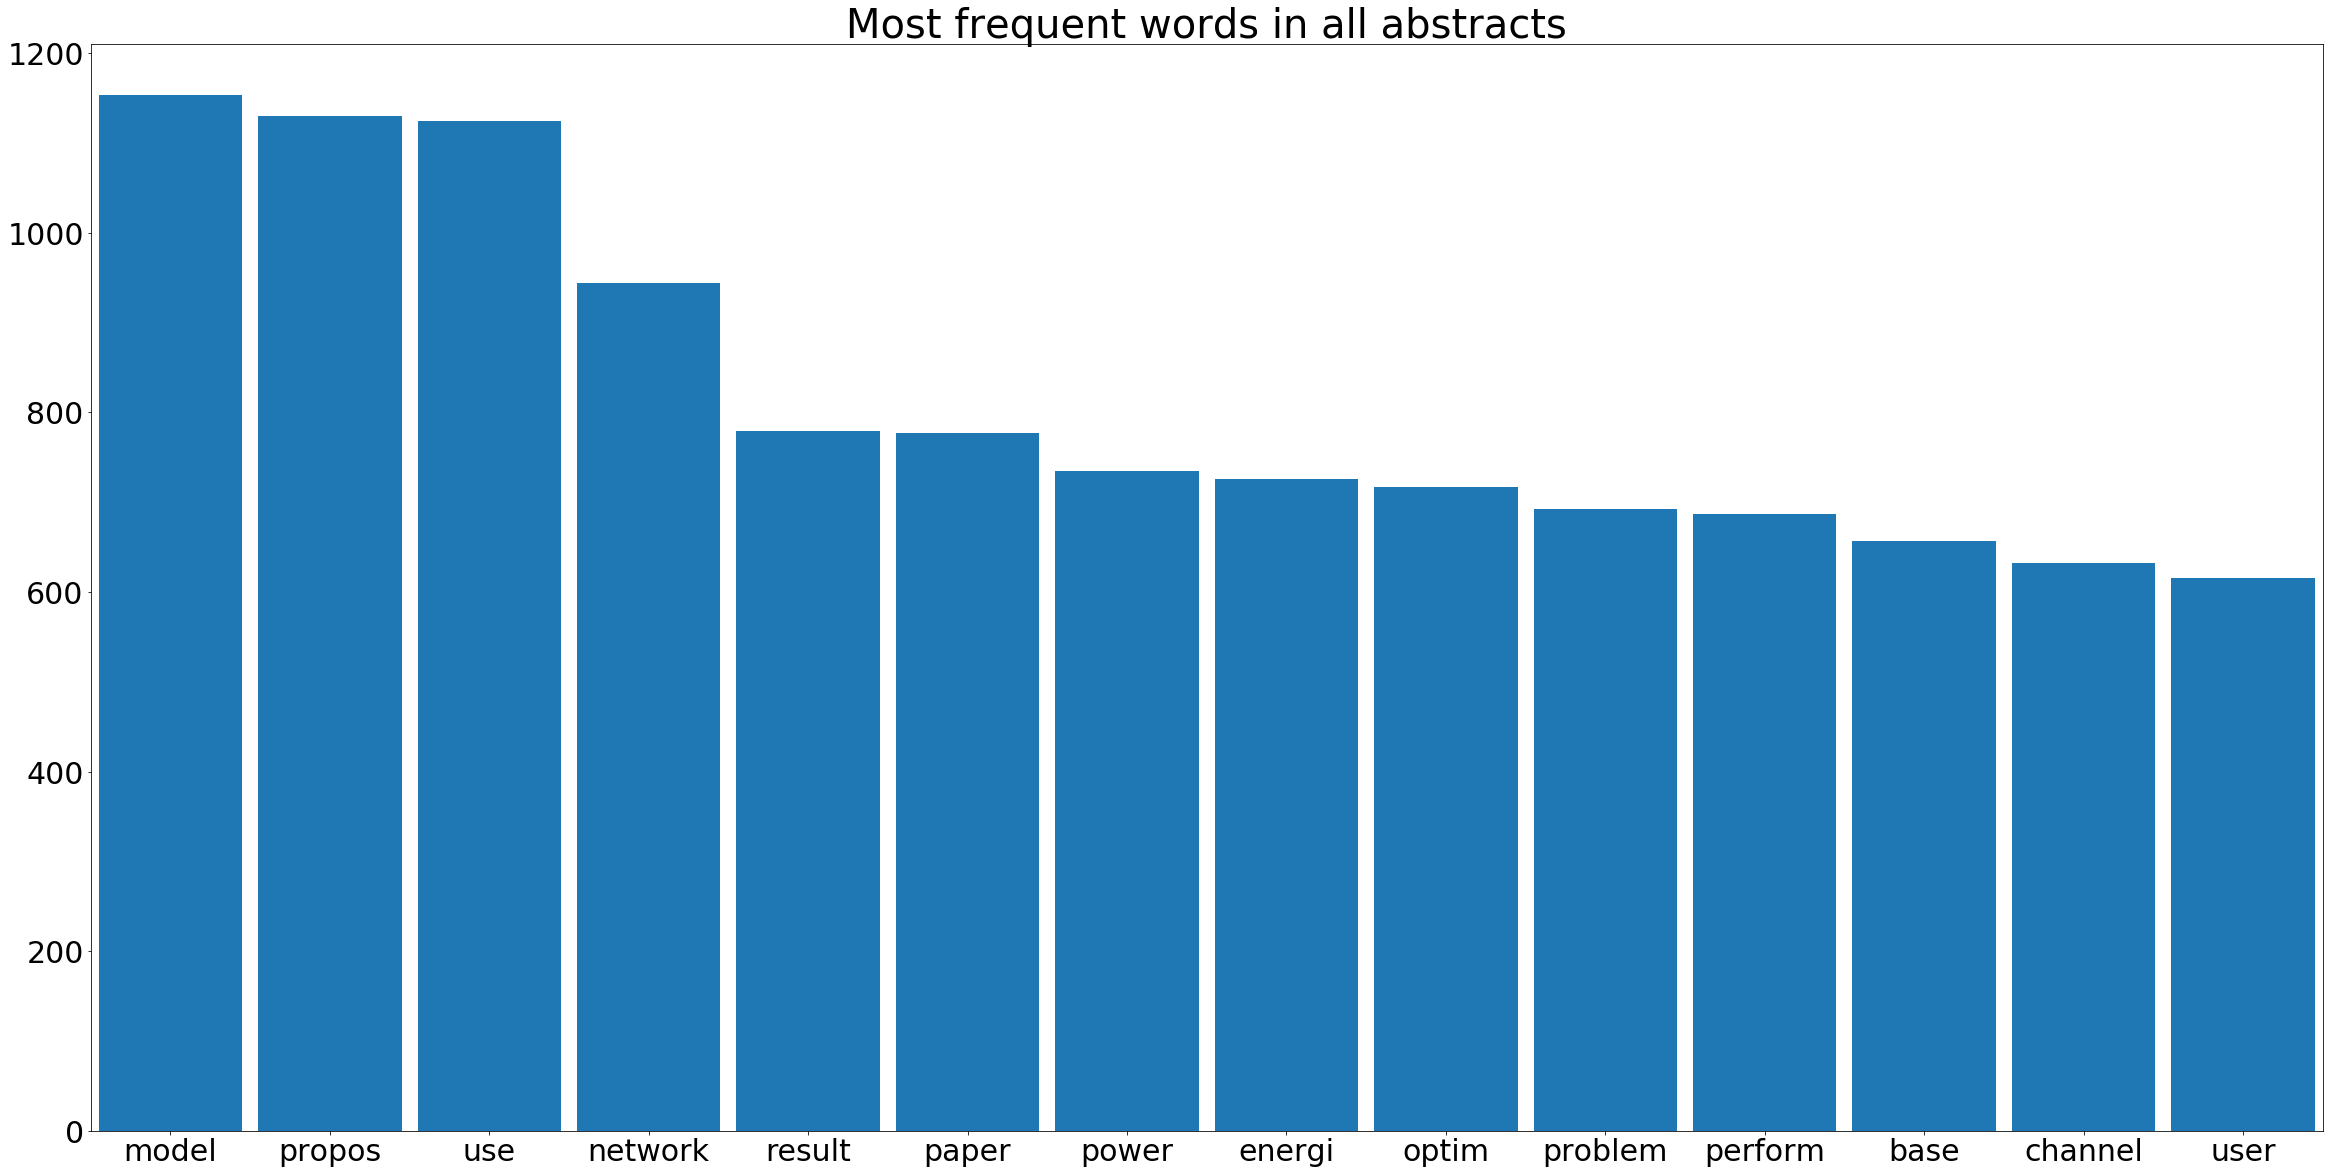

In [10]:
# Pareto Chart 
import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline

import matplotlib
# store in data frame
    # words as columns, authors as rows
    #           |  word 1   |  word 2   | word n
    #           _____________________________________
    #  author 1 | frequency | frequency | frequency
    #  author 2 | frequency | frequency | frequency
    #  author 3 | frequency | frequency | frequency   

abstract = df.iloc[0]
# print abstract.values[1]

common_words = ["a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]

counts_total = dict()

for index, row in df.iterrows():
    words = row.values[1].split()
    
    for word in words:
        counts_total[word] = counts_total.get(word,0) + 1
    for common_word in common_words:
        counts_total.pop(common_word, None)
    
# print counts_total

# sort counts in descending order
labels, heights = zip(*sorted(((k, v) for k, v in counts_total.items()), reverse=True))

from paretochart import pareto
fig, ax = plt.subplots(figsize=(40, 20))
pareto(heights, labels, cumplot=False, limit=0.1)
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.title('Most frequent words in all abstracts', fontsize=40)
plt.show()


Wordcloud of most frequent words in the corpus.

In [11]:
import Image
from wordcloud import WordCloud


ImportError: No module named Image

Principle Component Analysis to try to visualize the data. The first two PCA components only account for about 6 percent of variance in the data. When visualizing the scatter matrix of the first two components, the points do not seem to cluster together for a particular label but are randomly distributed.

In [ ]:


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)

print(pca.explained_variance_ratio_) 

reduced_data = pca.transform(x)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# scatterplot of the reduced data    

fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], s=70, alpha=0.5, c=labels)
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)

# Set plot title
ax.set_title("PCA-Reduced Data colored by label", fontsize=14)

In [ ]:
# heatmap

import seaborn as sns

sns.heatmap(x, annot=True, linewidth=.1, vmax=99, fmt='.1f', cmap='YlOrRd', square=True, cbar=False)

Subsample x and visualize word counts as heatmap...





As with any machine learning application, we want to split our data into training and testing datasets. I used StratifiedShuffleSplit to split the data and labels. After splitting, the training set is 1054 samples and the testing set is 118 samples.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for train_index, test_index in sss.split(x, labels_tf):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = labels_tf[train_index], labels_tf[test_index]
    
    # For logistic regression model, we simply need the labels (not one-hot vectors)
    labels_train, labels_test = df['author'][train_index], df['author'][test_index]

vocab_size = len(vocabulary)
doc_size = x_train.shape[1]
print "Train/test split: %d/%d" % (len(y_train), len(y_test))
print 'Train shape:', x_train.shape
print 'Test shape:', x_test.shape


### Benchmark Model
For the benchmark model, I chose to build Logistic Regression Model due to its simplicity and easy interpretation. The benchmark perform okay with the accuracy score on the test dataset of 0.6.

In [ ]:
from sklearn import linear_model
from time import time

print "starting log reg modeling..."

t0 = time()
clf = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42,
                                 multi_class="ovr").fit(x_train, labels_train)
pred = clf.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, labels_test)

tt = time()-t0
print("Training Log Regression took: {}").format(round(tt,3))
print "Accuracy score on test data is {}.".format(round(acc,4))

### Convolutional Neural Network Model
I used TensorFlow to build a multi-layer convolutional network. The first layer is embedding layer. 


In [ ]:
import tensorflow as tf
from time import time

num_classes = len(labels_unique)

x = tf.placeholder(tf.int32, [None, x_train.shape[1]], name="input_x")

# y_ is the correct classes
y_ = tf.placeholder(tf.float32, [None, num_classes], name="input_y")

# Keeping track of l2 regularization loss 
l2_loss = tf.constant(0.0)

embedding_size = 128
filter_sizes = [3,4,5]
num_filters = 128

# Embedding layer
W_emb = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedded_chars = tf.nn.embedding_lookup(W_emb, x)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)

The second layer is convolution and pooling layer with three different filter lengths of 3, 4, and 5 that are then combined. The pooling filters out the maximum value for each convolution to reduce the size of the layer. 

In [ ]:
# Create a convolution + maxpool layer for each filter size
pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    # Convolution Layer
    filter_shape = [filter_size, embedding_size, 1, num_filters]
    W_conv = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1))
    b_conv = tf.Variable(tf.constant(0.1, shape=[num_filters]))
    conv = tf.nn.conv2d(
        embedded_chars_expanded,
        W_conv,
        strides=[1, 1, 1, 1],
        padding="VALID")
    # Apply nonlinearity
    h = tf.nn.relu(tf.nn.bias_add(conv, b_conv))
    # Maxpooling over the outputs
    pooled = tf.nn.max_pool(
        h,
        ksize=[1, doc_size - filter_size + 1, 1, 1],
        strides=[1, 1, 1, 1],
        padding='VALID')
    pooled_outputs.append(pooled)

# Combine all the pooled features
num_filters_total = num_filters * len(filter_sizes)
h_pool = tf.concat(3, pooled_outputs)
h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])

To prune the network and reduce overfitting, we add dropout during training that disables the neurons that are less than 0.5 probability.

In [ ]:
# Add dropout
keep_prob = tf.placeholder(tf.float32)
h_drop = tf.nn.dropout(h_pool_flat, keep_prob)

The last layer is fully-connected layer with the softmax output classification. 

In [ ]:
# Unnormalized scores and predictions
W = tf.get_variable(
    "W",
    shape=[num_filters_total, num_classes],
    initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.constant(0.1, shape=[num_classes]))
l2_loss += tf.nn.l2_loss(W)
l2_loss += tf.nn.l2_loss(b)
scores = tf.nn.xw_plus_b(h_drop, W, b)
predictions = tf.argmax(scores, 1)

During training, we use Adam Optimizer to minimize the objective function.

In [ ]:
l2_reg_lambda=0.0

losses = tf.nn.softmax_cross_entropy_with_logits(scores, y_)
cross_entropy = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

# Accuracy score
correct_predictions = tf.equal(predictions, tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Training accuracy is computed for 500 iterations and printed every 100th step.

In [ ]:
t0 = time()
for i in range(500):
    # batch = mnist.train.next_batch(50)
    if i%100 == 0:

        train_accuracy = accuracy.eval(session=sess, feed_dict={ x: x_train, y_: y_train, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(session=sess, feed_dict={x: x_train, y_: y_train, keep_prob: 0.5})


tt = time()-t0
print("Training TensorFlow NN took: {}").format(round(tt,3))

The CNN test accuracy is 0.86.

In [ ]:
print("test accuracy %g"%accuracy.eval(session=sess, feed_dict={
    x: x_test, y_: y_test, keep_prob: 1.0}))